In [19]:
import subprocess
import sys

# List of required packages
required_packages = [
    "pandas",
    "matplotlib",
    "tensorflow",
    "seaborn",
    "scikit-learn"
]

# Install missing packages
for package in required_packages:
    try:
        __import__(package if package != "scikit-learn" else "sklearn")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Now safe to import
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

# Remove or comment out this line if not in a Jupyter notebook
# %matplotlib inline

# Suppress TensorFlow v1 logging (for legacy usage)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Make sure utils.py exists in the same folder
#try:
#    from utils import *
#except ImportError:
#    print("⚠️ 'utils.py' not found or failed to import.")


In [27]:
#Importing csv file data.csv and storing the data in 'df' 
df = pd.read_csv('data/housepricedata.csv', header = None) 
df.head() #Displaying the table


,0,1,2,3,4,5,6,7
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


In [28]:
# Adding column names to df
columns = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']
df.columns = columns
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


Some processing

In [29]:
# Check for null values in df 
df.isnull().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

In [30]:
# Drop serial column as it is not needed
df = df.iloc[:,1:] 
df.head()

,date,age,distance,stores,latitude,longitude,price
0,2009,21,9,6,84,121,14264
1,2007,4,2,3,86,121,12032
2,2016,18,3,7,90,120,13560
3,2002,13,2,2,80,128,12029
4,2014,25,5,8,81,122,14157


In [31]:
# Data normalization
df_normal = (df - df.mean()) / df.std()
df_normal.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [59]:
# Method to convert label value back to original value
# label valuues are normalized values thus we'll get predicted values in normalized form
# and we need to convert them back to original values for interpretation
import numpy as np

y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    # If pred is an array, take the first (and presumably only) element
    if isinstance(pred, (np.ndarray, list)) and len(pred) == 1:
        pred = pred[0]
    return int(pred * y_std + y_mean)

In [33]:
# Remove price column from df_normal for training and use it as label
X = df_normal.iloc[:, df_normal.columns != 'price']
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


In [35]:
Y = df_normal.iloc[:, df_normal.columns == 'price']
Y.head()

,price
0,0.350088
1,-1.836486
2,-0.339584
3,-1.839425
4,0.245266


In [36]:
X_values = X.values
Y_values = Y.values
print("X shape: ", X_values.shape)
print("Y shape: ", Y_values.shape)

X shape:  (5000, 6)
Y shape:  (5000, 1)


In [39]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_values, Y_values, test_size=0.05, shuffle=True, random_state=0)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750, 1)
X_test shape:  (250, 6)
y_test shape:  (250, 1)


In [40]:
import tensorflow.keras.backend as K

def r_squared_error(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # Add epsilon to avoid division by zero

In [41]:
# Working with numerical data - defining a NN model with no activation function => essentially a linear regression model
# Since regression problem relu activation function is used 
model = Sequential([
    Dense(10, input_shape = (6,), activation = 'relu'), #10 neurons, Input Layer
    Dense(20, activation = 'relu'),  #20 neurons, Hidden Layer
    Dense(5, activation = 'relu'),   #5  neurons, Hidden Layer
    Dense(1) 
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared_error, 'mean_absolute_error'])

model.summary()

c:\Users\alizc\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test) ,epochs=100, callbacks=[early_stopping])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1720 - mean_absolute_error: 0.8599 - r_squared_error: -0.1777 - val_loss: 0.4321 - val_mean_absolute_error: 0.5411 - val_r_squared_error: 0.4817
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3690 - mean_absolute_error: 0.4898 - r_squared_error: 0.6181 - val_loss: 0.1935 - val_mean_absolute_error: 0.3594 - val_r_squared_error: 0.7654
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1937 - mean_absolute_error: 0.3653 - r_squared_error: 0.7944 - val_loss: 0.1684 - val_mean_absolute_error: 0.3387 - val_r_squared_error: 0.7950
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1739 - mean_absolute_error: 0.3516 - r_squared_error: 0.8141 - val_loss: 0.1592 - val_mean_absolute_error: 0.3313 - val_r_squared_error: 0.8057
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1616 - mean_absolute_error: 0.3398 - r_squared_error: 0.8215 - val_loss: 0.1544 - val_mean_absolute_error: 0

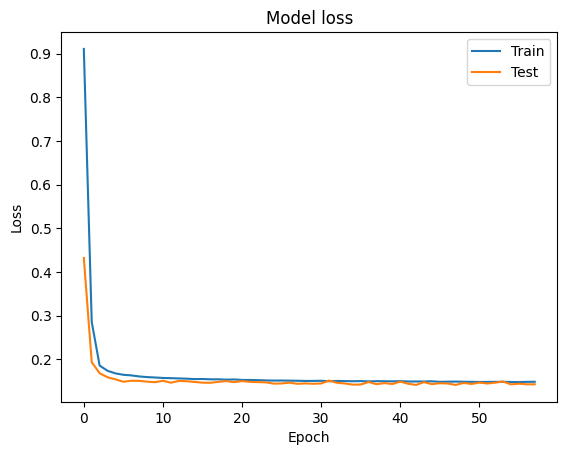

In [44]:
#plot training and validation loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [49]:
# Define a new model but with dropout layers to prevent overfitting
model_drop = Sequential([
    Dense(10, input_shape=(6,), activation='relu'),  # Input Layer
    Dropout(0.2),                                    # Dropout after first layer
    Dense(20, activation='relu'),                    # Hidden Layer
    Dropout(0.2),                                    # Dropout after second layer
    Dense(5, activation='relu'),                     # Hidden Layer
    Dropout(0.2),                                    # Dropout after third layer
    Dense(1)                                         # Output Layer
])
# Compile the model
model_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared_error, 'mean_absolute_error'])

# Train the model with dropout
history_drop = model_drop.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
model_drop.summary()


Epoch 1/100


c:\Users\alizc\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4263 - mean_absolute_error: 0.9329 - r_squared_error: -0.4495 - val_loss: 0.5252 - val_mean_absolute_error: 0.5748 - val_r_squared_error: 0.3731
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6975 - mean_absolute_error: 0.6628 - r_squared_error: 0.2600 - val_loss: 0.3887 - val_mean_absolute_error: 0.4923 - val_r_squared_error: 0.5375
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5264 - mean_absolute_error: 0.5695 - r_squared_error: 0.4493 - val_loss: 0.2927 - val_mean_absolute_error: 0.4303 - val_r_squared_error: 0.6514
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4709 - mean_absolute_error: 0.5421 - r_squared_error: 0.4853 - val_loss: 0.2707 - val_mean_absolute_error: 0.4163 - val_r_squared_error: 0.6777
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4273 - mean_absolute_error: 0.5182 - r_squared_error: 0.5557 - val_loss: 0.2397 - val_mean_absolute_error: 0.3947 - val_

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

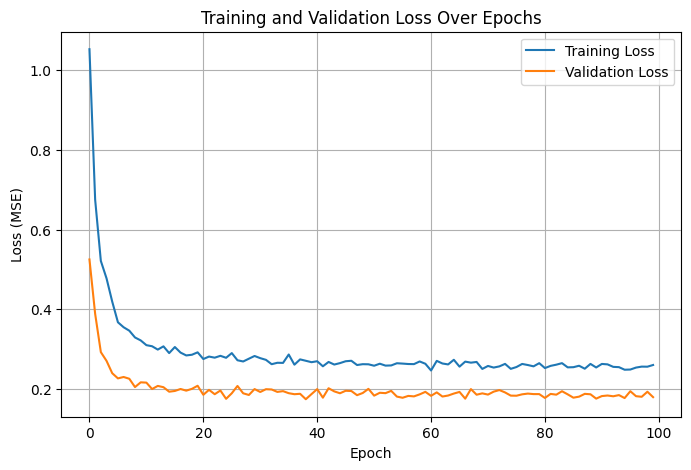

In [50]:

# Extract loss and val_loss from history
loss = history_drop.history['loss']
val_loss = history_drop.history['val_loss']

# Plotting
plt.figure(figsize=(8,5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

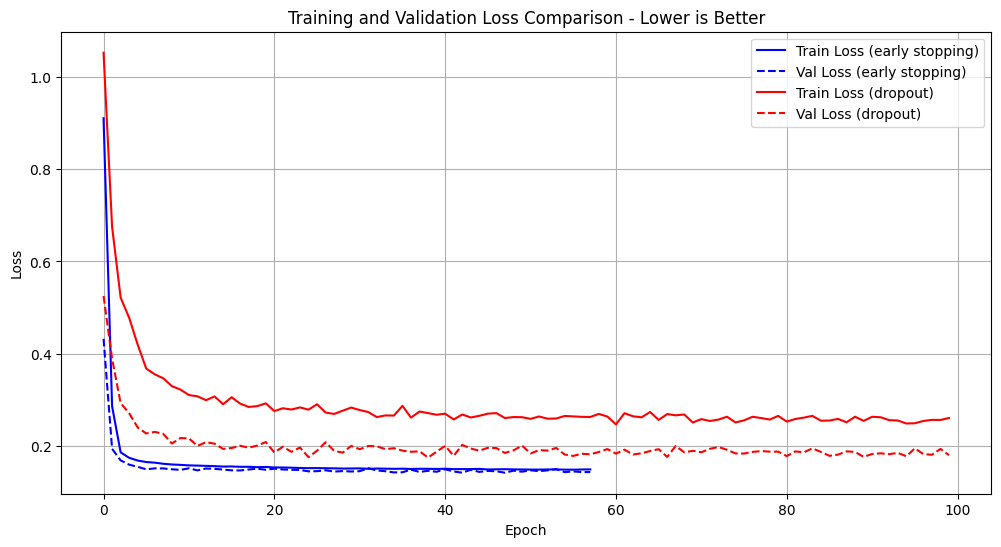

In [53]:
plt.figure(figsize=(12, 6))

# Original model loss
plt.plot(history.history['loss'], 'b-', label='Train Loss (early stopping)')
plt.plot(history.history['val_loss'], 'b--', label='Val Loss (early stopping)')

# Dropout model loss
plt.plot(history_drop.history['loss'], 'r-', label='Train Loss (dropout)')
plt.plot(history_drop.history['val_loss'], 'r--', label='Val Loss (dropout)')

plt.title('Training and Validation Loss Comparison - Lower is Better')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
predictions = model.predict(X_test)
price_on_trained_data =  [convert_label_value(y) for y in predictions]

pred_dropout = model_drop.predict(X_test)
price_on_trained_data_drop = [convert_label_value(y) for y in pred_dropout]

# Convert y_test to original price values
price_on_y_test = [convert_label_value(y) for y in y_test]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [72]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mae_early = mean_absolute_error(price_on_y_test, price_on_trained_data)
mae_dropout = mean_absolute_error(price_on_y_test, price_on_trained_data_drop)

mse_early = mean_squared_error(price_on_y_test, price_on_trained_data)
mse_dropout = mean_squared_error(price_on_y_test, price_on_trained_data_drop)

r2_early = r2_score(price_on_y_test, price_on_trained_data)
r2_dropout = r2_score(price_on_y_test, price_on_trained_data_drop)

print(f"MAE (Early Stopping): {mae_early:.2f}")
print(f"MAE (Dropout): {mae_dropout:.2f}")
print("")
print(f"MSE (Early Stopping): {mse_early:.2f}")
print(f"MSE (Dropout): {mse_dropout:.2f}")
print("")

print("R² - closer to 1 is better")
print(f"R² (Early Stopping): {r2_early:.3f}")
print(f"R² (Dropout): {r2_dropout:.3f}")


MAE (Early Stopping): 326.31
MAE (Dropout): 355.64

MSE (Early Stopping): 149171.91
MSE (Dropout): 187275.38

R² - closer to 1 is better
R² (Early Stopping): 0.834
R² (Dropout): 0.792


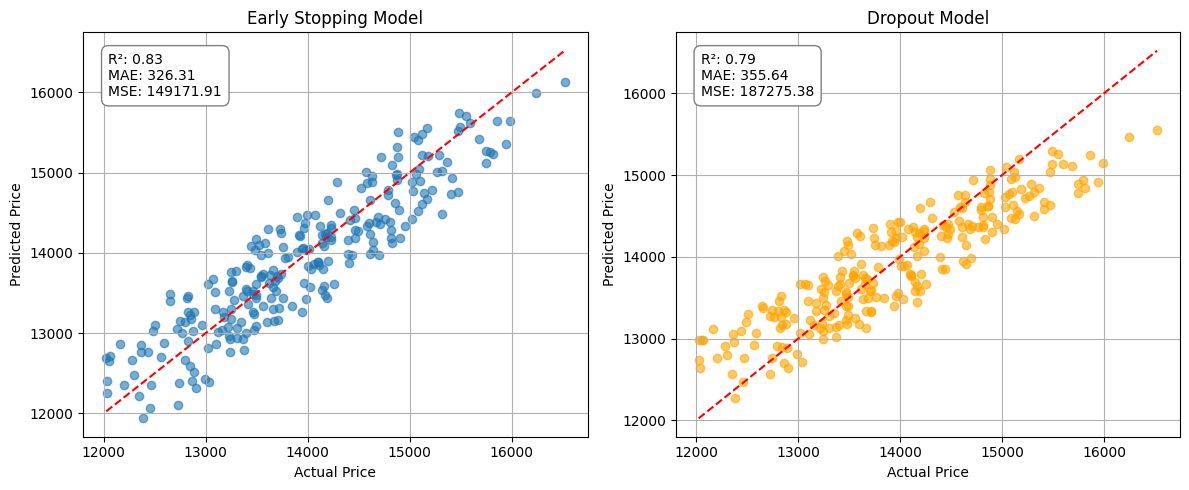

In [75]:


plt.figure(figsize=(12, 5))

# Early Stopping model
plt.subplot(1, 2, 1)
plt.scatter(price_on_y_test, price_on_trained_data, alpha=0.6)
plt.plot([min(price_on_y_test), max(price_on_y_test)], 
         [min(price_on_y_test), max(price_on_y_test)], 'r--')
plt.title('Early Stopping Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Add text for metrics
plt.text(0.05, 0.95, f'R²: {r2_early:.2f}\nMAE: {mae_early:.2f}\nMSE: {mse_early:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Dropout model
plt.subplot(1, 2, 2)
plt.scatter(price_on_y_test, price_on_trained_data_drop, alpha=0.6, color='orange')
plt.plot([min(price_on_y_test), max(price_on_y_test)], 
         [min(price_on_y_test), max(price_on_y_test)], 'r--')
plt.title('Dropout Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Add text for metrics
plt.text(0.05, 0.95, f'R²: {r2_dropout:.2f}\nMAE: {mae_dropout:.2f}\nMSE: {mse_dropout:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


In [81]:
final_gap_early = history.history['val_loss'][-1] - history.history['loss'][-1]
final_gap_drop = history_drop.history['val_loss'][-1] - history_drop.history['loss'][-1]

print("A larger gap = higher chance of overfitting")
print(f"Train/Val Loss Gap (Early Stopping): {final_gap_early:.4f}")
print(f"Train/Val Loss Gap (Dropout):  {final_gap_drop:.4f}")


A larger gap = higher chance of overfitting
Train/Val Loss Gap (Early Stopping): -0.0058
Train/Val Loss Gap (Dropout):  -0.0807
